<a href="https://colab.research.google.com/github/XavierCarrera/platzi-master-ml-exercises/blob/main/AmazonProducts_RecommendationSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction and Problem Definition

In [ ]:
!pip install scikit-surprise

In [80]:
import os
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn import preprocessing

import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [67]:
df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/db/reviews_Musical_Instruments.json', lines=True)
df.to_csv('reviews.csv', sep=',', index=False)

In [4]:
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YS9MDZP93857,0006428320,John Taylor,"[0, 0]",The portfolio is fine except for the fact that...,3,Parts missing,1394496000,"03 11, 2014"
1,A3TS466QBAWB9D,0014072149,Silver Pencil,"[0, 0]",If you are a serious violin student on a budge...,5,"Perform it with a friend, today!",1370476800,"06 6, 2013"
2,A3BUDYITWUSIS7,0041291905,joyce gabriel cornett,"[0, 0]",This is and excellent edition and perfectly tr...,5,Vivalldi's Four Seasons,1381708800,"10 14, 2013"
3,A19K10Z0D2NTZK,0041913574,TexasCowboy,"[0, 0]",Perfect for someone who is an opera fan or a w...,5,Full score: voice and orchestra,1285200000,"09 23, 2010"
4,A14X336IB4JD89,0201891859,dfjm53,"[0, 1]",How many Nocturnes does it contain? All of the...,1,Unable to determine contents,1350432000,"10 17, 2012"
...,...,...,...,...,...,...,...,...,...
500171,A2XEVARMJP81E,B00LIR7QNS,Zoe,"[0, 0]","I'm very pleased with this recorder. Firstly, ...",5,"Excellent sound, very cheap, altos are rather ...",1405641600,"07 18, 2014"
500172,A3PAQGM6P87MXO,B00LJD5AUM,William Kilpatrick,"[0, 0]",i've been playing my m-4 for more years than i...,5,... years than i care to remember - it's a won...,1404518400,"07 5, 2014"
500173,A2KZX7A4XZ4T2W,B00LK7A9SK,Steve,"[1, 1]",This is an exceptionally nice sounding guitar....,5,great sound,1404518400,"07 5, 2014"
500174,AIDHT6KXOL64T,SMLRBIMX03,Leo Cameron,"[0, 0]",It was a perfect retrofit for my guitar. I lov...,5,A great choice for my guitar,1355788800,"12 18, 2012"


In [ ]:
df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [68]:
df.drop(["unixReviewTime", "reviewTime", "helpful"], axis=1, inplace=True)
df

,reviewerID,asin,reviewerName,reviewText,overall,summary
0,A1YS9MDZP93857,0006428320,John Taylor,The portfolio is fine except for the fact that...,3,Parts missing
1,A3TS466QBAWB9D,0014072149,Silver Pencil,If you are a serious violin student on a budge...,5,"Perform it with a friend, today!"
2,A3BUDYITWUSIS7,0041291905,joyce gabriel cornett,This is and excellent edition and perfectly tr...,5,Vivalldi's Four Seasons
3,A19K10Z0D2NTZK,0041913574,TexasCowboy,Perfect for someone who is an opera fan or a w...,5,Full score: voice and orchestra
4,A14X336IB4JD89,0201891859,dfjm53,How many Nocturnes does it contain? All of the...,1,Unable to determine contents
...,...,...,...,...,...,...
500171,A2XEVARMJP81E,B00LIR7QNS,Zoe,"I'm very pleased with this recorder. Firstly, ...",5,"Excellent sound, very cheap, altos are rather ..."
500172,A3PAQGM6P87MXO,B00LJD5AUM,William Kilpatrick,i've been playing my m-4 for more years than i...,5,... years than i care to remember - it's a won...
500173,A2KZX7A4XZ4T2W,B00LK7A9SK,Steve,This is an exceptionally nice sounding guitar....,5,great sound
500174,AIDHT6KXOL64T,SMLRBIMX03,Leo Cameron,It was a perfect retrofit for my guitar. I lov...,5,A great choice for my guitar


In [ ]:
df.isnull().sum().sum()

2586

In [ ]:
df.isnull().any()

reviewerID      False
asin            False
reviewerName     True
helpful         False
reviewText      False
overall         False
summary         False
dtype: bool

In [69]:
df.drop(["reviewerName"], axis=1, inplace=True)
df

,reviewerID,asin,reviewText,overall,summary
0,A1YS9MDZP93857,0006428320,The portfolio is fine except for the fact that...,3,Parts missing
1,A3TS466QBAWB9D,0014072149,If you are a serious violin student on a budge...,5,"Perform it with a friend, today!"
2,A3BUDYITWUSIS7,0041291905,This is and excellent edition and perfectly tr...,5,Vivalldi's Four Seasons
3,A19K10Z0D2NTZK,0041913574,Perfect for someone who is an opera fan or a w...,5,Full score: voice and orchestra
4,A14X336IB4JD89,0201891859,How many Nocturnes does it contain? All of the...,1,Unable to determine contents
...,...,...,...,...,...
500171,A2XEVARMJP81E,B00LIR7QNS,"I'm very pleased with this recorder. Firstly, ...",5,"Excellent sound, very cheap, altos are rather ..."
500172,A3PAQGM6P87MXO,B00LJD5AUM,i've been playing my m-4 for more years than i...,5,... years than i care to remember - it's a won...
500173,A2KZX7A4XZ4T2W,B00LK7A9SK,This is an exceptionally nice sounding guitar....,5,great sound
500174,AIDHT6KXOL64T,SMLRBIMX03,It was a perfect retrofit for my guitar. I lov...,5,A great choice for my guitar


In [ ]:
df.dtypes

reviewerID    object
asin          object
helpful       object
reviewText    object
overall        int64
summary       object
dtype: object

In [ ]:
df.duplicated().sum().sum()

0

In [ ]:
df.isnull().sum().sum()

0

# Exploratory Data Analysis

In [ ]:
products = len(np.unique(df.asin))
print("Total products: " + str(products))

Total products: 83046


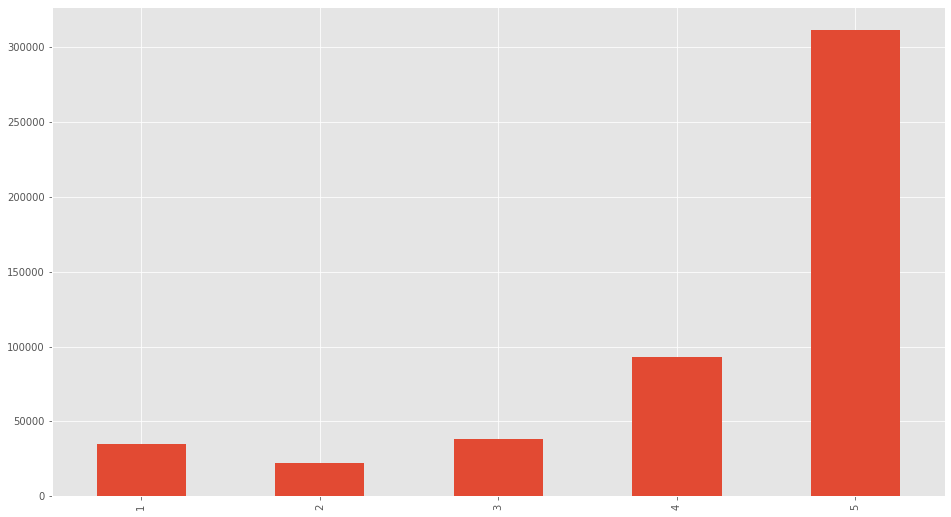

In [ ]:
df["overall"].value_counts().sort_index().plot(kind = "bar")

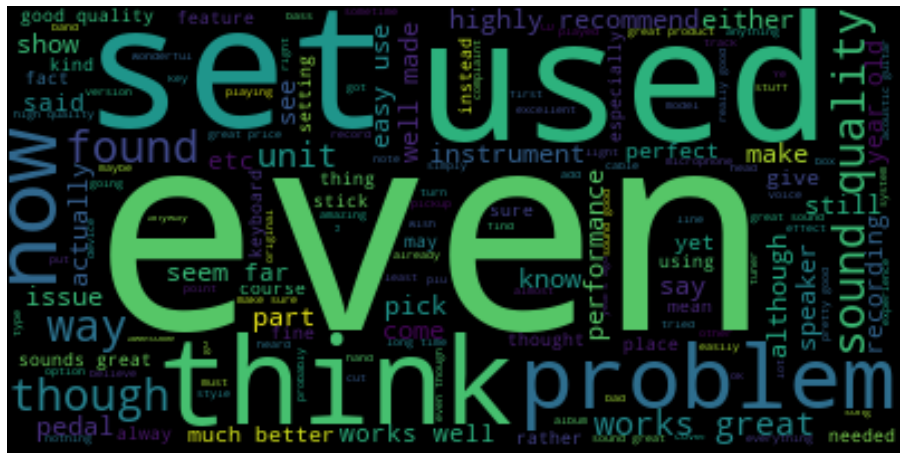

In [ ]:
"text = " ".join(review for review in df.reviewText)
cloud = WordCloud().generate(text)

plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

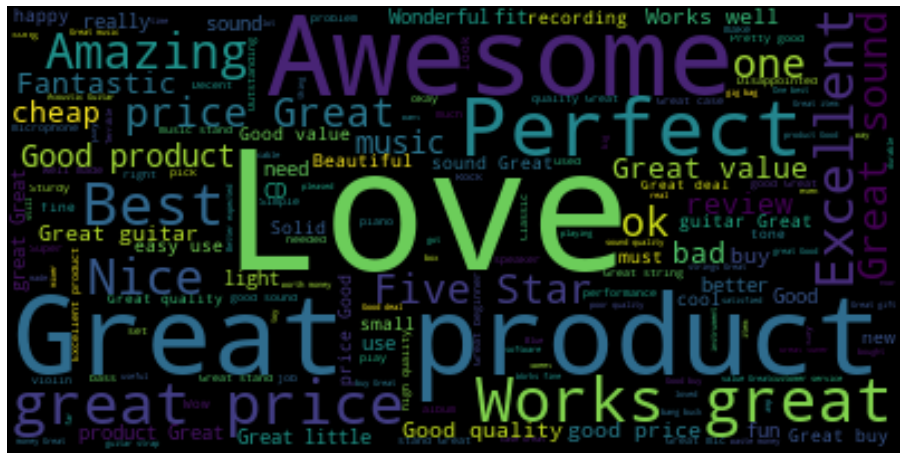

In [ ]:
text = " ".join(review for review in df.summary)
cloud = WordCloud().generate(text)

plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [58]:
reviewers = df.groupby("reviewerID")["overall"].count().sort_values(ascending=False)
reviewers

reviewerID
A2PAD826IH1HFE           483
A2AIMXT9PLAM12           463
A2NYK9KWFMJV4Y           454
A33GGROUQRQZS            154
A2PR6NXG0PA3KY           135
                        ... 
A3DTVMQGMNLX26             1
A3DTWDOB8PFXCN             1
A3DTWRE957F5ZK             1
A3DTXPIA1LW4LI             1
A0002382258OFJJ2UYNTR      1
Name: overall, Length: 339231, dtype: int64

In [59]:
reviewers.describe()

count    339231.000000
mean          1.474441
std           2.342608
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         483.000000
Name: overall, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


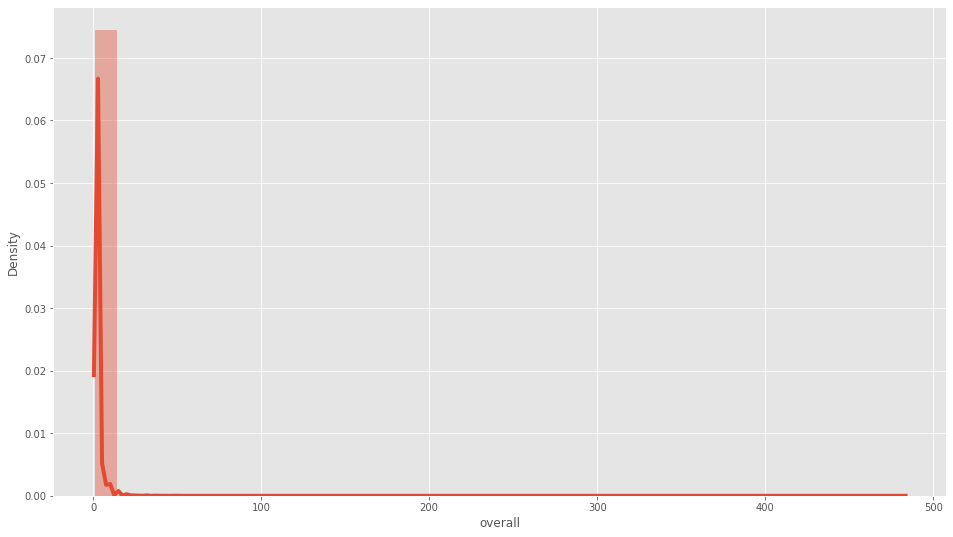

In [51]:
sns.distplot(reviewers, hist=True, kde=True, bins=int(180/5), kde_kws={'linewidth': 4})

In [13]:
model = pd.DataFrame(df.groupby('asin')["overall"].mean())
model["total_overall"] = pd.DataFrame(df.groupby('asin')["overall"].count())
model

,overall,total_overall
asin,,
0006428320,3.0,1
0014072149,5.0,1
0041291905,5.0,1
0041913574,5.0,1
0201891859,1.0,1
...,...,...
B00LEWRD80,2.0,1
B00LIR7QNS,5.0,1
B00LJD5AUM,5.0,1


In [ ]:
model.describe()

,overall,total_overall
count,83046.000000,83046.000000
mean,4.231531,6.022879
std,0.983354,28.294073
min,1.000000,1.000000
25%,4.000000,1.000000
50%,4.515625,2.000000
75%,5.000000,4.000000
max,5.000000,3523.000000


Text(0, 0.5, 'Total Number of Reviews')

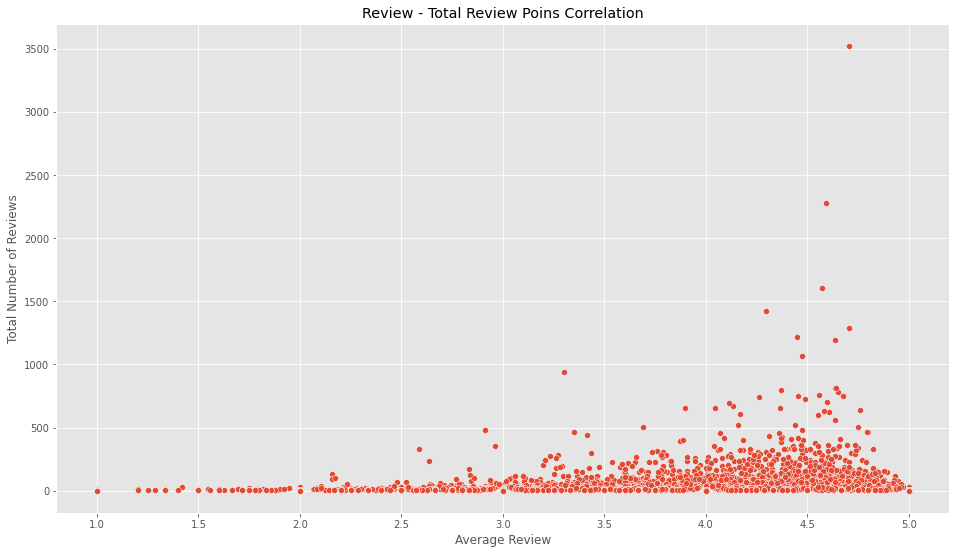

In [31]:
sns.scatterplot(x = model["overall"], y= model["total_overall"])
plt.title("Review - Total Review Poins Correlation")
plt.xlabel("Average Review")
plt.ylabel("Total Number of Reviews")

In [ ]:
model.columns

Index(['overall', 'total_overall'], dtype='object')

In [34]:
model["Score"] = model["overall"] * model["total_overall"]
model.sort_values(by="Score", ascending=False, inplace=True)
model

,overall,total_overall,Score
asin,,,
B000ULAP4U,4.703946,3523,16572.0
B003VWJ2K8,4.592527,2275,10448.0
B003VWKPHC,4.574548,1603,7333.0
B001MSS6CS,4.295775,1420,6100.0
B00FPPQYXM,4.706294,1287,6057.0
...,...,...,...
B004NGWE5G,1.000000,1,1.0
B004NGWFPU,1.000000,1,1.0
B004NGYR4W,1.000000,1,1.0


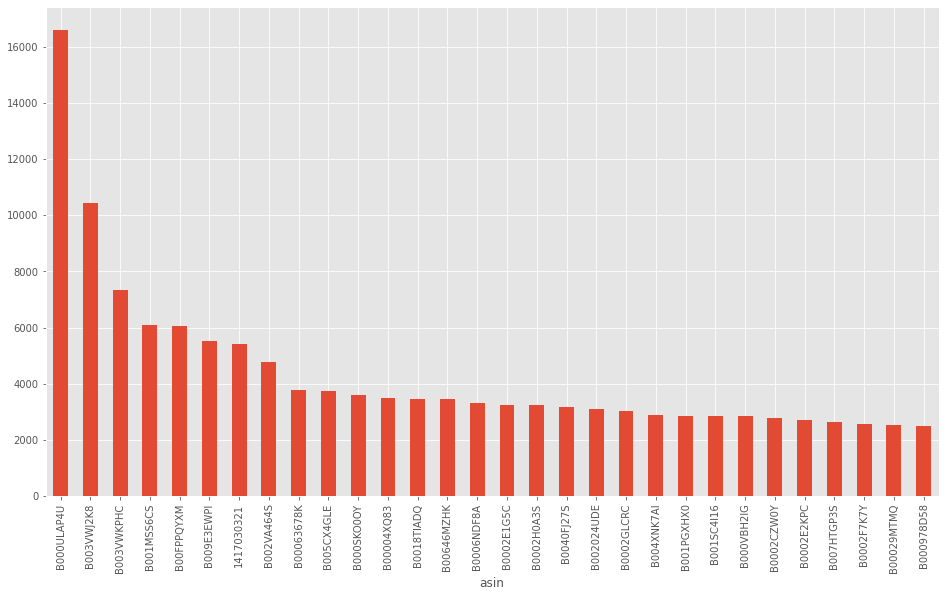

In [35]:
model["Score"].head(30).plot(kind = "bar")

# Collaborative Filtering

In [81]:
filter_df = df.drop(["summary", "reviewText"], axis=1)

In [82]:
le = preprocessing.LabelEncoder()
filter_df = filter_df.apply(le.fit_transform)
filter_df

,reviewerID,asin,overall
0,86974,0,2
1,253074,1,4
2,208692,2,4
3,24206,3,4
4,12731,4,0
...,...,...,...
500171,172688,83042,4
500172,242009,83043,4
500173,141937,83044,4
500174,295302,83045,4


In [83]:
filter_df = filter_df[filter_df.overall >= 3]
filter_df.groupby(by="overall").agg("count")

,reviewerID,asin
overall,,
3,93306,93306
4,310784,310784


In [84]:
min_ratings = 10
filter_books = filter_df["asin"].value_counts() > min_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 10
filter_users = df["reviewerID"].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

train_df = filter_df[(filter_df["asin"].isin(filter_books)) & (df["reviewerID"].isin(filter_users))]

train_df.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


(13433, 3)

In [85]:
reader = Reader(rating_scale=(1,5))
train_df = Dataset.load_from_df(train_df, reader)

In [86]:
benchmark = []

for algorithm in [KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore()]:
    
    results = cross_validate(algorithm, train_df, measures=["RMSE"], cv=3, verbose=False)
    
   
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=["Algorithm"]))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index("Algorithm").sort_values("test_rmse") 

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,fit_time,test_time
Algorithm,,,
KNNBaseline,0.439590,0.127887,0.077505
KNNWithZScore,0.453391,0.152620,0.082846
KNNBasic,0.453545,0.088429,0.078121
KNNWithMeans,0.454077,0.101130,0.072955


In [87]:
bsl_options = {"method": "als","n_epochs": 5, "reg_u": 12,"reg_i": 5}

In [88]:
knn_b = KNNBaseline(bsl_options = bsl_options)
cross_validate(knn_b, train_df, measures=["RMSE"], cv=3, verbose=False)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


{'fit_time': (0.11077618598937988, 0.10465049743652344, 0.10496163368225098),
 'test_rmse': array([0.4383767 , 0.43978184, 0.43924013]),
 'test_time': (0.07416033744812012, 0.07623124122619629, 0.07471323013305664)}

In [89]:
trainset, testset = train_test_split(train_df, test_size=0.25)
algo = KNNBaseline(bsl_options = bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4401


0.44006757428408316

In [96]:
def get_Iu(uid):
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df_pred = pd.DataFrame(predictions, columns=["Product ID", "User ID", "rui", "est", "details"])
df_pred["Items rated by user"] = df_pred["Product ID"].apply(get_Iu)
df_pred["Users ratings"] = df_pred["User ID"].apply(get_Ui)
df_pred["Error"] = abs(df_pred.est - df_pred.rui)

df_pred

,Product ID,User ID,rui,est,details,Items rated by user,Users ratings,Error
0,199506,61840,4.0,3.808074,{'was_impossible': False},8,0,0.191926
1,259549,30047,3.0,3.888697,"{'actual_k': 0, 'was_impossible': False}",4,3,0.888697
2,377,12249,4.0,3.457997,"{'actual_k': 3, 'was_impossible': False}",5,25,0.542003
3,84861,41619,4.0,3.728673,"{'actual_k': 0, 'was_impossible': False}",9,1,0.271327
4,305049,4823,4.0,3.736181,{'was_impossible': False},6,0,0.263819
...,...,...,...,...,...,...,...,...
3354,160472,21876,4.0,3.811062,{'was_impossible': False},4,0,0.188938
3355,45004,59360,4.0,3.853463,"{'actual_k': 0, 'was_impossible': False}",3,1,0.146537
3356,127165,6251,4.0,4.061435,"{'actual_k': 2, 'was_impossible': False}",5,24,0.061435
3357,105261,68029,4.0,3.876382,"{'actual_k': 0, 'was_impossible': False}",6,1,0.123618


In [97]:
df_pred["Error"].describe()

count    3359.000000
mean        0.342453
std         0.276421
min         0.000118
25%         0.140480
50%         0.233816
75%         0.520157
max         1.294211
Name: Error, dtype: float64

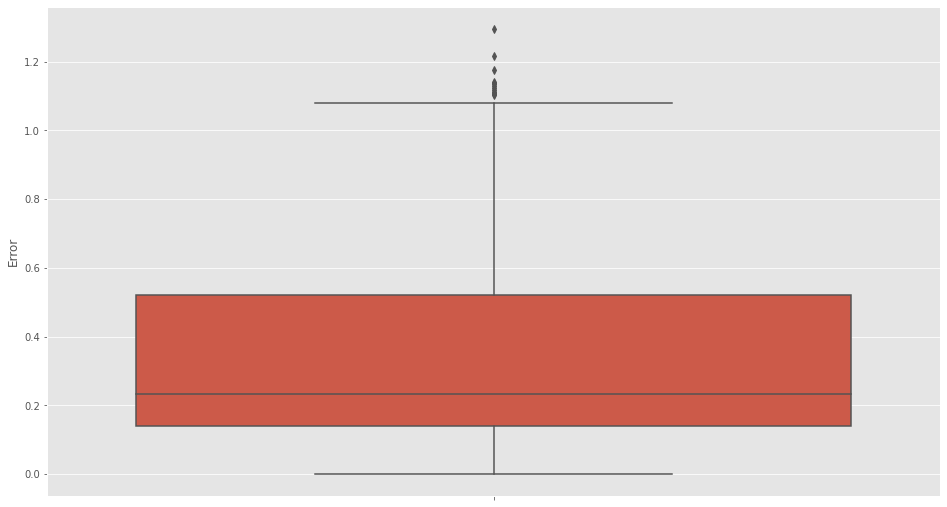

In [98]:
sns.boxplot(y = df_pred["Error"])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


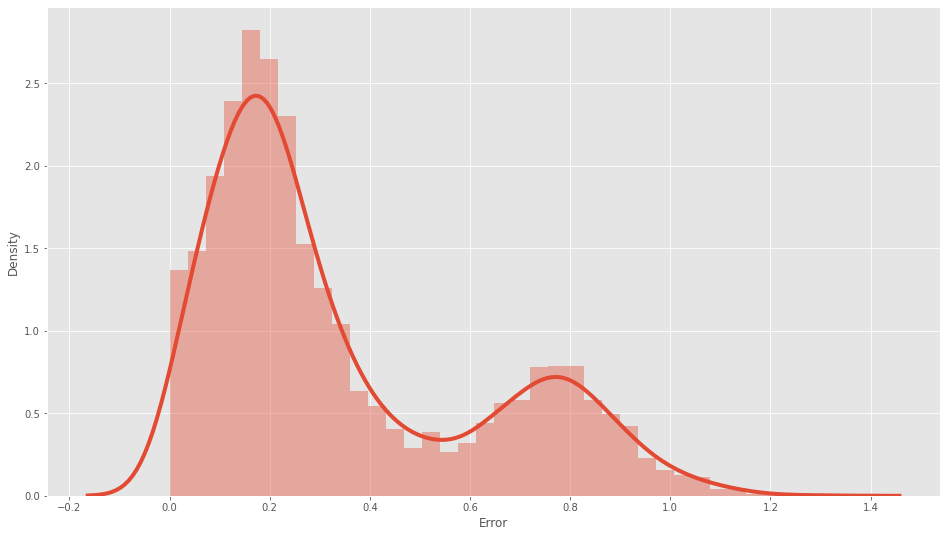

In [99]:
sns.distplot(df_pred["Error"], hist=True, kde=True, bins=int(180/5), kde_kws={'linewidth': 4})

# Testing

In [115]:
top_recommendations = df_pred.sort_values(by="Error")[:10]
top_recommendations

,Product ID,User ID,rui,est,details,Items rated by user,Users ratings,Error
793,149304,18726,4.0,4.000118,"{'actual_k': 0, 'was_impossible': False}",62,2,0.000118
638,297763,47340,4.0,3.999750,"{'actual_k': 1, 'was_impossible': False}",20,2,0.000250
2802,106226,8951,4.0,4.000368,"{'actual_k': 1, 'was_impossible': False}",15,1,0.000368
1391,169349,26739,4.0,4.000478,"{'actual_k': 1, 'was_impossible': False}",5,3,0.000478
1731,226999,17232,4.0,4.000777,"{'actual_k': 1, 'was_impossible': False}",4,4,0.000777
1777,158771,8028,3.0,3.001062,"{'actual_k': 1, 'was_impossible': False}",2,7,0.001062
272,189914,21475,4.0,4.001226,"{'actual_k': 2, 'was_impossible': False}",7,4,0.001226
1869,12704,47682,4.0,4.001284,"{'actual_k': 2, 'was_impossible': False}",5,13,0.001284
2449,310580,40552,4.0,3.998493,"{'actual_k': 1, 'was_impossible': False}",9,7,0.001507
1660,203737,57715,4.0,4.001925,"{'actual_k': 1, 'was_impossible': False}",6,3,0.001925
